# vessel experiments

In [92]:
import dicom
from dicom.errors import InvalidDicomError

import numpy as np
from PIL import Image, ImageDraw

from matplotlib.pyplot import imshow
import os

In [106]:
def parse_dicom_file(filename):
    """Parse the given DICOM filename

    :param filename: filepath to the DICOM file to parse
    :return: dictionary with DICOM image data
    """
    try:
        dcm = dicom.read_file(filename)
        dcm_image = dcm.pixel_array

        try:
            intercept = dcm.RescaleIntercept
        except AttributeError:
            intercept = 0.0
        try:
            slope = dcm.RescaleSlope
        except AttributeError:
            slope = 0.0

        if intercept != 0.0 and slope != 0.0:
            dcm_image = dcm_image*slope + intercept
        dcm_dict = {'pixel_data' : dcm_image}
        return dcm_dict
    except InvalidDicomError:
        return None

## Use hasattr instead of try...except

In [115]:
def parse_dicom_file_optimized(filename):
    """Parse the given DICOM filename

    :param filename: filepath to the DICOM file to parse
    :return: dictionary with DICOM image data
    """
    try:
        dcm = dicom.read_file(filename)
        dcm_image = dcm.pixel_array

        #intercept = getattr(dcm, 'RescaleIntercept', None)
        #slope = getattr(dcm, 'RescaleSlope', None)
        #if intercept and slope:
        #    dcm_image = dcm_image*slope + intercept
        if hasattr(dcm, 'RescaleIntercept') and hasattr(dcm, 'RescaleSlope'):
            dcm_image = dcm_image*dcm.RescaleSlope + dcm.RescaleIntercept
        dcm_dict = {'pixel_data' : dcm_image}
        return dcm_dict
    except InvalidDicomError:
        return None

In [72]:
def parse_contour_file(filename):
    """Parse the given contour filename

    :param filename: filepath to the contourfile to parse
    :return: list of tuples holding x, y coordinates of the contour
    """
    
    coords_lst = []

    with open(filename, 'r') as infile:
        for line in infile:
            coords = line.strip().split()

            x_coord = float(coords[0])
            y_coord = float(coords[1])
            coords_lst.append((x_coord, y_coord))

    return coords_lst

In [11]:
def poly_to_mask(polygon, width, height):
    """Convert polygon to mask

    :param polygon: list of pairs of x, y coords [(x1, y1), (x2, y2), ...]
     in units of pixels
    :param width: scalar image width
    :param height: scalar image height
    :return: Boolean mask of shape (height, width)
    """

    # http://stackoverflow.com/a/3732128/1410871
    img = Image.new(mode='L', size=(width, height), color=0)
    ImageDraw.Draw(img).polygon(xy=polygon, outline=0, fill=1)
    mask = np.array(img).astype(bool)
    return mask

## Explore file content

In [6]:
img = parse_dicom_file('data/dicoms/SCD0000101/1.dcm')

In [8]:
img

{'pixel_data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int16)}

In [12]:
mask = poly_to_mask(c, dcm.Columns, dcm.Rows)

In [13]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [56]:
dcm = dicom.read_file('data/dicoms/SCD0000101/48.dcm')
dcm

(0008, 0000) Group Length                        UL: 676
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'CARDIAC', 'NONE']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 2.16.124.113543.6006.99.3391139613699913089
(0008, 0020) Study Date                          DA: '20120000'
(0008, 0021) Series Date                         DA: '20120000'
(0008, 0022) Acquisition Date                    DA: '20120000'
(0008, 0023) Content Date                        DA: '20120000'
(0008, 0030) Study Time                          TM: '083237.000000'
(0008, 0031) Series Time                         TM: '083859'
(0008, 0032) Acquisition Time                    TM: '084011.485317'
(0008, 0033) Content Time                        TM: '084020.319653'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality            

## Visualize DICOM image & plot with mask

In [18]:
def get_LUT_value(data, window, level):
    """Apply the RGB Look-Up Table for the given data and window/level value."""
    return np.piecewise(data,
                        [data <= (level - 0.5 - (window - 1) / 2),
                         data > (level - 0.5 + (window - 1) / 2)],
                        [0, 255, lambda data: ((data - (level - 0.5)) / (window - 1) + 0.5) * (255 - 0)])

In [47]:
%matplotlib inline
def show_PIL(dicom_object, polygon):
    if ('PixelData' not in dicom_object):
        raise TypeError("Cannot show image -- DICOM dataset does not have pixel data")
    if ('WindowWidth' not in dicom_object) or ('WindowCenter' not in dicom_object):  # can only apply LUT if these values exist
        bits = dicom_object.BitsAllocated
        samples = dicom_object.SamplesPerPixel
        if bits == 8 and samples == 1:
            mode = "L"
        elif bits == 8 and samples == 3:
            mode = "RGB"
        elif bits == 16:
            mode = "I;16"  # not sure about this -- PIL source says is 'experimental' and no documentation. Also, should bytes swap depending on endian of file and system??
        else:
            raise TypeError("Don't know PIL mode for %d BitsAllocated and %d SamplesPerPixel" % (bits, samples))

        # PIL size = (width, height)
        size = (dicom_object.Columns, dicom_object.Rows)

        im = Image.frombuffer(mode, size, dicom_object.PixelData, "raw", mode, 0, 1)  # Recommended to specify all details by http://www.pythonware.com/library/pil/handbook/image.htm

    else:
        image = get_LUT_value(dicom_object.pixel_array, dicom_object.WindowWidth, dicom_object.WindowCenter)
        im = Image.fromarray(image).convert('L')  # Convert mode to L since LUT has only 256 values: http://www.pythonware.com/library/pil/handbook/image.htm

    ImageDraw.Draw(im).polygon(xy=polygon, outline=255, fill=0)
    imshow(np.asarray(im))
    #im.show()

In [53]:
c = parse_contour_file('data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0059-icontour-manual.txt')

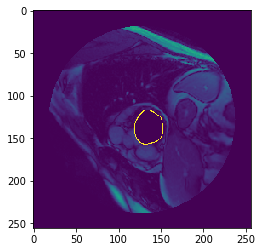

In [57]:
show_PIL(dcm, c)

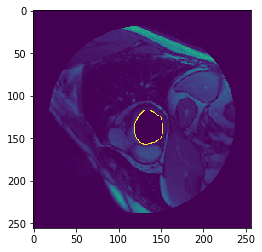

In [55]:
show_PIL(dcm, c)

In [81]:
import os
import timeit

In [84]:
dcm_files = []
for dirname, dirnames, filenames in os.walk('data/dicoms'):
    
    # print path to all filenames.
    for filename in filenames:
        if '._' not in filename:
            dcm_files.append(os.path.join(dirname, filename))
dcm_files

['data/dicoms/SCD0000201/58.dcm',
 'data/dicoms/SCD0000201/227.dcm',
 'data/dicoms/SCD0000201/78.dcm',
 'data/dicoms/SCD0000201/104.dcm',
 'data/dicoms/SCD0000201/93.dcm',
 'data/dicoms/SCD0000201/129.dcm',
 'data/dicoms/SCD0000201/13.dcm',
 'data/dicoms/SCD0000201/99.dcm',
 'data/dicoms/SCD0000201/166.dcm',
 'data/dicoms/SCD0000201/46.dcm',
 'data/dicoms/SCD0000201/230.dcm',
 'data/dicoms/SCD0000201/217.dcm',
 'data/dicoms/SCD0000201/127.dcm',
 'data/dicoms/SCD0000201/54.dcm',
 'data/dicoms/SCD0000201/15.dcm',
 'data/dicoms/SCD0000201/139.dcm',
 'data/dicoms/SCD0000201/195.dcm',
 'data/dicoms/SCD0000201/161.dcm',
 'data/dicoms/SCD0000201/180.dcm',
 'data/dicoms/SCD0000201/155.dcm',
 'data/dicoms/SCD0000201/150.dcm',
 'data/dicoms/SCD0000201/45.dcm',
 'data/dicoms/SCD0000201/34.dcm',
 'data/dicoms/SCD0000201/182.dcm',
 'data/dicoms/SCD0000201/49.dcm',
 'data/dicoms/SCD0000201/1.dcm',
 'data/dicoms/SCD0000201/47.dcm',
 'data/dicoms/SCD0000201/243.dcm',
 'data/dicoms/SCD0000201/167.dcm',

In [102]:

statement1 = '''
from __main__ import parse_dicom_file
for dcm_file in dcm_files:
    parse_dicom_file(dcm_file)
'''
t = timeit.Timer(stmt=statement1, setup='dcm_files={}'.format(dcm_files))
print("{}".format(statement1))
print("%.2f msec/pass\n" % (1000 * t.timeit(number=3)/3))




from __main__ import parse_dicom_file
for dcm_file in dcm_files:
    parse_dicom_file(dcm_file)

1251.64 msec/pass



In [116]:
statement2 = '''
from __main__ import parse_dicom_file_optimized
for dcm_file in dcm_files:
    parse_dicom_file_optimized(dcm_file)
'''
t = timeit.Timer(stmt=statement2, setup='dcm_files={}'.format(dcm_files))
print("{}".format(statement1))
print("%.2f msec/pass\n" % (1000 * t.timeit(number=3)/3))



from __main__ import parse_dicom_file
for dcm_file in dcm_files:
    parse_dicom_file(dcm_file)

1250.73 msec/pass

